In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [61]:
##Creating directories
dir = r'./autism_dataset/'
train_dir = os.path.join(dir,'train')
test_dir = os.path.join(dir,'test')
val_dir = os.path.join(dir,'valid')
print(train_dir)

./autism_dataset/train


In [62]:
## Defining Batch Size and Image Size 
batch_size = 32
img_size = (180,180)

In [63]:
##creates the datasets 
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size)

val_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  image_size=img_size)
test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size)

Found 2538 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [64]:
class_names = train_dataset.class_names


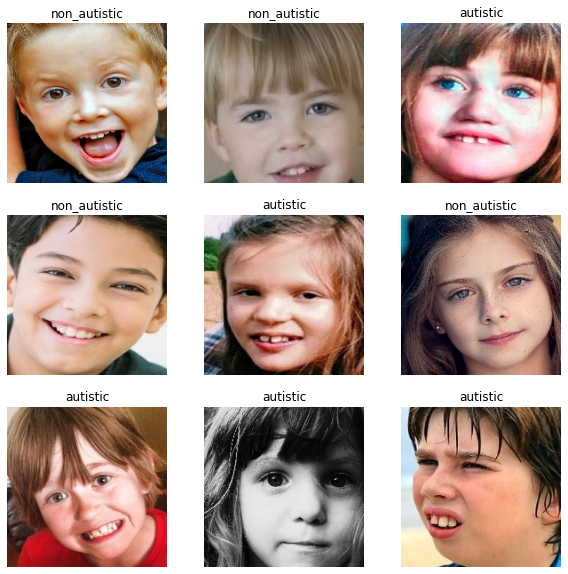

In [65]:
##Visualizes data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [66]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break  

(32, 180, 180, 3)
(32,)


In [67]:
## configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [68]:
IMG_SHAPE = img_size + (3,)

In [69]:
## fix overfitting with data augmentation 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=IMG_SHAPE),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [70]:
## Create model
img_height = 180
img_width = 180

num_classes = 5

## fix overfitting with dropout!
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [71]:
##Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [73]:
## Train model 
epochs=10
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10
80/80 [==============================] - 90s 1s/step - loss: 0.7103 - accuracy: 0.5705 - val_loss: 0.6611 - val_accuracy: 0.6100
Epoch 2/10
80/80 [==============================] - 73s 918ms/step - loss: 0.6089 - accuracy: 0.6643 - val_loss: 0.5976 - val_accuracy: 0.6600
Epoch 3/10
80/80 [==============================] - 78s 982ms/step - loss: 0.6084 - accuracy: 0.6769 - val_loss: 0.6245 - val_accuracy: 0.6150
Epoch 4/10
80/80 [==============================] - 79s 992ms/step - loss: 0.5642 - accuracy: 0.7072 - val_loss: 0.5935 - val_accuracy: 0.6450
Epoch 5/10
80/80 [==============================] - 77s 962ms/step - loss: 0.5512 - accuracy: 0.7270 - val_loss: 0.6355 - val_accuracy: 0.6950
Epoch 6/10
80/80 [==============================] - 69s 862ms/step - loss: 0.5336 - accuracy: 0.7313 - val_loss: 0.5614 - val_accuracy: 0.6850
Epoch 7/10
80/80 [==============================] - 63s 789ms/step - loss: 0.5181 - accuracy: 0.7411 - val_loss: 0.5372 - val_accuracy: 0.7000
Ep

Mean Validation Accuracy: 0.6909999966621398
Mean Training Accuracy:0.7092986583709717
Mean Validation Loss: 0.568756741285324
Mean Training Loss:0.558018833398819


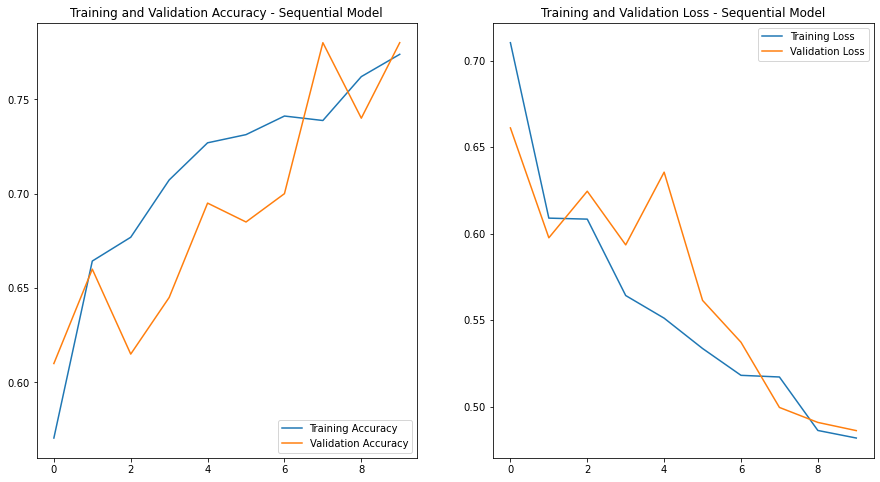

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Means of accuracy
sum_acc = 0
for i in range(len(acc)):
    sum_acc = sum_acc + acc[i]
    acc_mean = sum_acc / len(acc)

sum_val_acc = 0
for i in range(len(val_acc)):
    sum_val_acc = sum_val_acc + val_acc[i]
    val_acc_mean = sum_val_acc / len(val_acc)

print('Mean Validation Accuracy: ' + str(val_acc_mean))
print('Mean Training Accuracy:' + str(acc_mean))

#Means of Loss
sum_loss = 0
for i in range(len(loss)):
    sum_loss = sum_loss + loss[i]
    loss_mean = sum_loss / len(loss)

sum_val_loss = 0
for i in range(len(val_loss)):
    sum_val_loss = sum_val_loss + val_loss[i]
    val_loss_mean = sum_val_loss / len(val_loss)

print('Mean Validation Loss: ' + str(val_loss_mean))
print('Mean Training Loss:' + str(loss_mean))

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Sequential Model')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Sequential Model')
plt.show()

In [79]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 3s 350ms/step - loss: 0.1828 - accuracy: 0.9200
Test accuracy : 0.9200000166893005


Predictions:
 [1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1
 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0
 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1
 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0
 0 0 1 1 0 0 0 1 1 0 0 0]
Labels:
 [0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1]


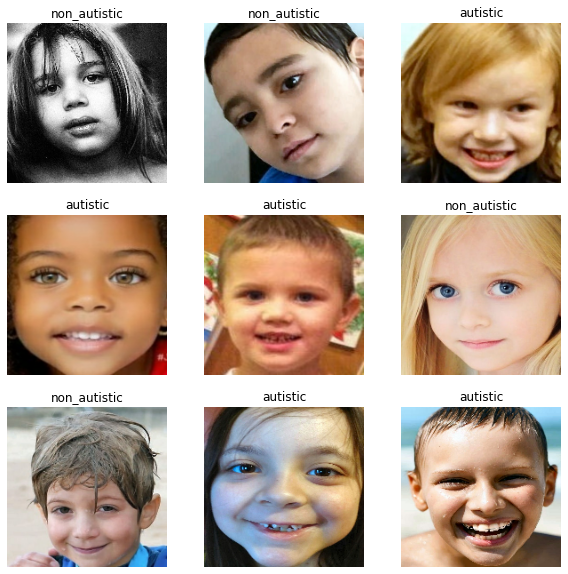

In [80]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")